# Training the VOC Tables model

*Gerhard de Kok (datamanager at the [Huygens Institute](https://www.huygens.knaw.nl/))*

The goal of this notebook is to train a machine learning model that can process handwritten tables containing employment information on individuals in the service of the Dutch East India Company (Vereenigde Oost-Indische Compagnie - VOC). Using the code from this notebook, the training process can be replicated.

## Overview
The VOC employed hundreds of thousands of individuals throughout its nearly two-century-long existence. Its personnel administration was divided into two parts: a Dutch and an Asian administration. The Dutch administration for the eighteenth century has been largely preserved and is available as [structured data](https://doi.org/10.5281/zenodo.10599528). One overarching goal of the project *Immigration and social mobility: the case of the eighteenth-century Dutch Republic* is to create structured data for the extant Asian personnel records. By linking these two datasets, it will become possible to trace the career paths of individuals throughout the Company.

The Dutch National Archives provides [online access](https://www.nationaalarchief.nl/onderzoeken/zoekhulpen/overzicht-van-voc-archieven-1594-1814) to the digitized records of the VOC. We are particularly interested in the main VOC archive (1.04.02), inventory numbers [5168 through 5239](https://www.nationaalarchief.nl/onderzoeken/archief/1.04.02/invnr/5168) (Amsterdam Chamber) and [11534 through 11820](https://www.nationaalarchief.nl/onderzoeken/archief/1.04.02/invnr/11534) (Zeeland Chamber). These records contain the *Generale land- en zeemonsterrollen* (General Land and Sea Muster Rolls). To extract structured data on the individuals mentioned in these sources, it is essential to train a table recognition model capable of processing each digitized page as a handwritten table and extracting individual data points from each cell.

## Training process
This notebooks employs the [Detectron2 framework](https://github.com/facebookresearch/detectron2) to segment the scanned pages into rows and columns. Table cells can subsequently be determined by interpolating the boundaries of these rows and columns.  Detectron2 enables the testing of various model architectures and pretrained models. For this project, we utilized a pre-trained Mask R-CNN model trained on [Publaynet](https://paperswithcode.com/dataset/publaynet). This model is available in the [Model Zoo](https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html) of the Layout Parser Python package (though the Layout Parser package itself was not used in this project). More specifically, we used the pretrained weights available as publay_mask_rcnn_R_50_FPN_3x. 

## Training data
The training data consists of 237 pages of ground truth annotations (second half eighteenth century from the Amsterdam Chamber). These annotations were created using the Transkribus online editor, which provides an intuitive interface for marking tables in scanned documents. The resulting PAGE XML files from Transkribus were converted into the COCO data format using a custom script included in this repository. This script creates masks for rows and columns, there masks are stored in COCO format using polygons.

### A Note on Table Layout

The records targeted by this model resemble the following sample from the 1770 books ([Inventory Number 5218](https://www.nationaalarchief.nl/onderzoeken/archief/1.04.02/invnr/5218)):

<div style="display: flex; justify-content: center; align-items: center; gap: 20px; max-width: 640px; margin: auto; padding: 10px 0;">
    <div style="text-align: center;">
        <img src="data/notebook_images/NL-HaNA_1.04.02_5218_0030-klein.jpg" alt="Left Page" style="width: 300px; border: 1px solid #ddd; border-radius: 5px;"/>
        <p><em>Left Page</em></p>
    </div>
    <div style="text-align: center;">
        <img src="data/notebook_images/NL-HaNA_1.04.02_5218_0031-klein.jpg" alt="Right Page" style="width: 300px; border: 1px solid #ddd; border-radius: 5px;"/>
        <p><em>Right Page</em></p>
    </div>
</div>

Left and right pages have been scanned separately by the archive.
- Left pages contain two columns:  
  1. **Name**  
  2. **Place of Origin**
- Right pages contain seven columns:  
  1. **Job Title**  
  2. **Monthly Salary**  
  3. **Totals Column**  
  4. **First Point of Employment**  
  5. **First Year of Employment**  
  6. **Original Job Title**  
  7. **VOC Chamber**

While the layout from the 1770 books is relatively consistent, earlier records show slight variations. For example, here is a sample from the 1720 books ([inventory number 5168](https://www.nationaalarchief.nl/onderzoeken/archief/1.04.02/invnr/5168)):
<div style="display: flex; justify-content: center; align-items: center; gap: 20px; max-width: 640px; margin: auto; padding: 10px 0;">
    <div style="text-align: center;">
        <img src="data/notebook_images/NL-HaNA_1.04.02_5168_1800-klein.jpg" alt="Left Page" style="width: 300px; border: 1px solid #ddd; border-radius: 5px;"/>
        <p><em>Left Page</em></p>
    </div>
    <div style="text-align: center;">
        <img src="data/notebook_images/NL-HaNA_1.04.02_5168_1801-klein.jpg" alt="Right Page" style="width: 300px; border: 1px solid #ddd; border-radius: 5px;"/>
        <p><em>Right Page</em></p>
    </div>
</div>

Here, the left page contains just one column containing the name and place of origin. In addition, right pages contain an extra column. 

In [1]:
import os
import math
import numpy as np

import torch 
import time

import detectron2
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
# Monkey-patch np.bool to avoid breaking Detectron2 code due to version mismatch
if not hasattr(np, 'bool'):
    np.bool = bool

/tmp/ipykernel_855/1393248182.py:2: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


In [3]:
# First, we register the Dutch East India Company (VOC) dataset with Detectron2
register_coco_instances("VOC_train", {}, "data/training/annotations-train.json", "data/training/Images")
register_coco_instances("VOC_val", {}, "data/training/annotations-val.json", "data/training/Images")
register_coco_instances("VOC_all", {}, "data/training/annotations.json", "data/training/Images")

# These annotations contain two classes: TableRow and TableColumn
MetadataCatalog.get("VOC_train").thing_classes = ["TableRow", "TableColumn"]
MetadataCatalog.get("VOC_val").thing_classes = ["TableRow", "TableColumn"]
MetadataCatalog.get("VOC_all").thing_classes = ["TableRow", "TableColumn"]

In [4]:
# Adjust batch size and epochs
train_dataset = DatasetCatalog.get("VOC_train")
batch_size = 4 
epoch = math.ceil(len(train_dataset) / float(batch_size))  # Epoch size based on the dataset
epoch_num = 10  # Total number of epochs

cfg = get_cfg()
cfg.merge_from_file("models/publay_mask_rcnn_R_50_FPN_3x/config.yml")
cfg.MODEL.WEIGHTS = "models/publay_mask_rcnn_R_50_FPN_3x/model_final.pth"  # Path to pre-trained weights

# Configure datasets
cfg.DATASETS.TRAIN = ("VOC_train",)
cfg.DATASETS.TEST = ("VOC_val",)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 'row' and 'column'

os.makedirs("models/voc_tables/", exist_ok=True)
cfg.OUTPUT_DIR = 'models/voc_tables/'

# Hyperparameters
cfg.SOLVER.BASE_LR = 0.0001  # Base learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Batch size per image for ROI head
cfg.SOLVER.MAX_ITER = epoch * 12 # Total number of iterations; 12x epoch size
cfg.DATALOADER.NUM_WORKERS = 2  # Number of workers for the dataloader
cfg.SOLVER.IMS_PER_BATCH = batch_size  # Images per batch
cfg.SOLVER.STEPS = (4000, 5000)  # Learning rate schedule steps
cfg.SOLVER.WARMUP_ITERS = 150

# Mixed Precision Training
cfg.SOLVER.AMP.ENABLED = True

# # Validation config
# val_cfg = cfg.clone()
# val_cfg.MODEL.WEIGHTS = f"../model_weights/model_final.pth"  # Use the latest saved weights
# # val_cfg.DATASETS.TEST = ("VOC_val",)
# val_cfg.DATALOADER.NUM_WORKERS = 0  # Reduce workers
# val_cfg.SOLVER.IMS_PER_BATCH = 1 # Use a single image per batch during validation
# val_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Adjust if necessary
# val_cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 500  # Reduce proposals
# val_cfg.TEST.DETECTIONS_PER_IMAGE = 50  # Reduce detections per image
# val_cfg.INPUT.MIN_SIZE_TEST = 640  # Minimum resolution for validation
# val_cfg.INPUT.MAX_SIZE_TEST = 800  # Maximum resolution for validation

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has no attribute '_evt'


[01/21 17:17:11 d2.data.datasets.coco]: Loaded 213 images in COCO format from data/training/annotations-train.json


Running in a loop to avoid GPU memory problems. 
Note: on my local machine I have (temporarily?) turned off the validation step after each epoch, since it continues to give VRAM issues.

In [5]:
# ######## FUNCTION FOR TRAINING ########
def train_model(cfg, max_iter, epoch_num):

    cfg.SOLVER.MAX_ITER = max_iter
    print(f"Training until {max_iter} iterations.")

    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=True) 
    trainer.train()

    # Save weights after each epoch
    model_weights_path = f"models/voc_tables/model_epoch_{epoch_num}.pth"
    torch.save(trainer.model.state_dict(), model_weights_path)
    print(f"Saved model weights to {model_weights_path}")

    del trainer
    torch.cuda.empty_cache()


# ######## FUNCTION FOR VALIDATION ########
def validate_model(cfg, epoch_num):
    print("Sleeping for 10 seconds.") # Wait for clearing VRAM
    time.sleep(10)

    eval_cfg = cfg.clone()
    eval_cfg.MODEL.WEIGHTS = f"models/voc_tables/model_epoch_{epoch_num}.pth"  # Use current epoch's weights
    eval_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # Lower treshold to save VRAM
    eval_cfg.DATALOADER.NUM_WORKERS = 1  # Reduce workers to save VRAM
    eval_cfg.SOLVER.IMS_PER_BATCH = 1  

    eval_cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 1000
    eval_cfg.INPUT.MIN_SIZE_TEST = 800
    eval_cfg.INPUT.MAX_SIZE_TEST = 1333

    from detectron2.modeling import build_model
    model = build_model(eval_cfg)
    model.load_state_dict(torch.load(eval_cfg.MODEL.WEIGHTS))
    model.eval()
    model.to(torch.device("cuda"))

    from detectron2.evaluation import COCOEvaluator, inference_on_dataset
    from detectron2.data import build_detection_test_loader
    evaluator = COCOEvaluator("VOC_val", output_dir="./eval_output")
    val_loader = build_detection_test_loader(eval_cfg, "VOC_val")

    results = inference_on_dataset(model, val_loader, evaluator)
    print(f"Validation results for epoch {epoch_num}: {results}")

    del model, evaluator, val_loader
    torch.cuda.empty_cache()


# ######## DETECT LAST COMPLETED EPOCH ########
def get_last_completed_epoch():
    checkpoint_dir = "../models/voc_tables/"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("model_epoch_") and f.endswith(".pth")]
    if checkpoints:
        # Get the epoch number from the latest checkpoint
        checkpoints.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        last_checkpoint = checkpoints[-1]
        last_epoch = int(last_checkpoint.split("_")[-1].split(".")[0])
        print(f"Resuming from epoch {last_epoch}.")
        return last_epoch
    print("No checkpoints found. Starting from epoch 1.")
    return 0

# ######## TRAIN AND VALIDATE FOR MULTIPLE EPOCHS ########
# Get the initial MAX_ITER
initial_max_iter = cfg.SOLVER.MAX_ITER

# Get the last completed epoch
last_completed_epoch = get_last_completed_epoch()

for i in range(last_completed_epoch, epoch_num):
    print(f"EPOCH {i + 1}")

    # Calculate the new MAX_ITER
    max_iter = initial_max_iter * (i + 1)
    cfg.SOLVER.MAX_ITER = max_iter

    # Train the model
    train_model(cfg.clone(), max_iter, i + 1)

    # Validate the model
    # validate_model(cfg.clone(), i + 1)


No checkpoints found. Starting from epoch 1.
EPOCH 1
Training until 648 iterations.
[01/21 17:17:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        

/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/detectron2/engine/train_loop.py:379: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.ad

[01/21 17:17:17 d2.engine.train_loop]: Starting training from iteration 0


/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/detectron2/engine/train_loop.py:394: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730833640211/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the fir

[01/21 17:17:31 d2.utils.events]:  eta: 0:06:05  iter: 19  total_loss: 5.117  loss_cls: 1.172  loss_box_reg: 0.7519  loss_mask: 0.67  loss_rpn_cls: 2.07  loss_rpn_loc: 0.4869  time: 0.5933  data_time: 0.1328  lr: 1.2754e-05  max_mem: 2485M
[01/21 17:17:43 d2.utils.events]:  eta: 0:05:54  iter: 39  total_loss: 2.52  loss_cls: 0.705  loss_box_reg: 0.7603  loss_mask: 0.5051  loss_rpn_cls: 0.08442  loss_rpn_loc: 0.4478  time: 0.5962  data_time: 0.1298  lr: 2.6074e-05  max_mem: 2491M
[01/21 17:17:55 d2.utils.events]:  eta: 0:05:45  iter: 59  total_loss: 2.31  loss_cls: 0.6009  loss_box_reg: 0.744  loss_mask: 0.4736  loss_rpn_cls: 0.05477  loss_rpn_loc: 0.423  time: 0.6055  data_time: 0.1386  lr: 3.9394e-05  max_mem: 2491M
[01/21 17:18:08 d2.utils.events]:  eta: 0:05:39  iter: 79  total_loss: 2.196  loss_cls: 0.541  loss_box_reg: 0.7515  loss_mask: 0.4548  loss_rpn_cls: 0.04088  loss_rpn_loc: 0.3813  time: 0.6133  data_time: 0.1595  lr: 5.2714e-05  max_mem: 2539M
[01/21 17:18:20 d2.utils.eve

# Testing the VOC Tables model

Now that we have a trained model, let's test it!

In [3]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# Load the trained model configuration
cfg_test = get_cfg()
cfg_test.merge_from_file("models/publay_mask_rcnn_R_50_FPN_3x/config.yml")
cfg_test.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # Set testing confidence threshold
cfg_test.MODEL.ROI_HEADS.NUM_CLASSES = 2  # Number of classes
cfg_test.MODEL.WEIGHTS = "models/voc_tables/model_final.pth"  # Path to trained weights

# Define the metadata with category names
category_names = ["tableRow", "tableColumn"]
MetadataCatalog.get("custom_dataset").set(thing_classes=category_names)

# Initialize the predictor
predictor = DefaultPredictor(cfg_test)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has no attribute '_evt'
/home/gerhard/miniconda3/envs/voc/lib/python3.12/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weig

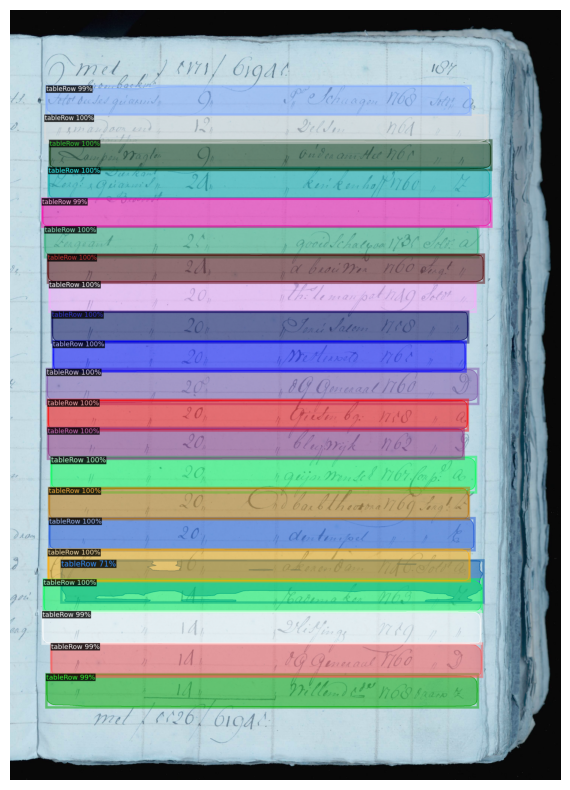

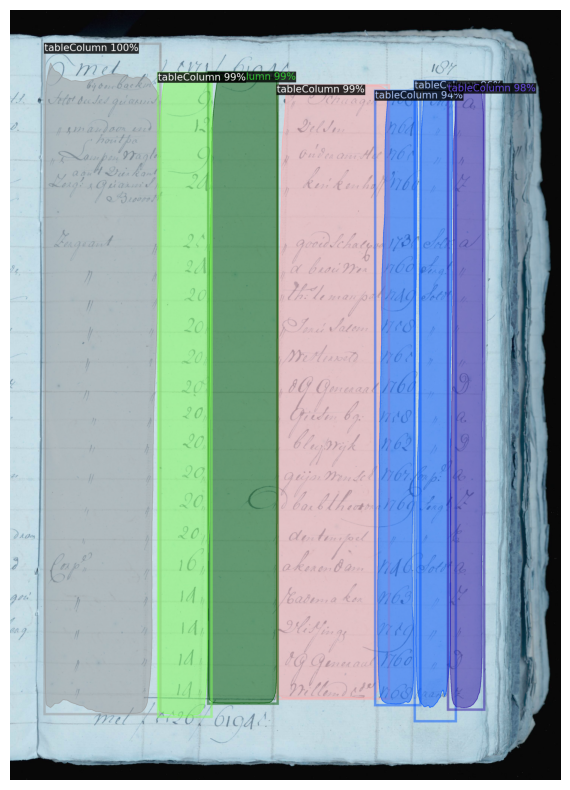

In [6]:
image_path = "data/testing/NL-HaNA_1.04.02_5218_0381.jpg"
img = cv2.imread(image_path)

outputs = predictor(img)
instances = outputs["instances"].to("cpu")

# Filtering to only show category 0 (tableRow) or 1 (tableColumn)
rows = instances[instances.pred_classes == 0]  
columns = instances[instances.pred_classes == 1]  

# # Draw bounding boxes manually
# for box in instances.pred_boxes.tensor.numpy():
#     x1, y1, x2, y2 = box
#     cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=2)  # Blue boxes

# # Display the image with bounding boxes
# plt.figure(figsize=(10, 10))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
# plt.axis("off")
# plt.show()

# Visualize predicted rows
v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("custom_dataset"), scale=0.5)
v = v.draw_instance_predictions(rows)
plt.figure(figsize=(10, 10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

# Visualize predicted columns
v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("custom_dataset"), scale=0.5)
v = v.draw_instance_predictions(columns)
plt.figure(figsize=(10, 10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()